In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## Pascal VOC

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[WindowsPath('data/pascal/models'),
 WindowsPath('data/pascal/pascal_test2007.json'),
 WindowsPath('data/pascal/pascal_train2007.json'),
 WindowsPath('data/pascal/pascal_train2012.json'),
 WindowsPath('data/pascal/pascal_val2007.json'),
 WindowsPath('data/pascal/pascal_val2012.json'),
 WindowsPath('data/pascal/tmp'),
 WindowsPath('data/pascal/VOC2007'),
 WindowsPath('data/pascal/VOC2012'),
 WindowsPath('data/pascal/VOCtrainval_11-May-2012.tar')]

In [4]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [8]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [9]:
list((PATH/'VOC2007').iterdir())

[WindowsPath('data/pascal/VOC2007/Annotations'),
 WindowsPath('data/pascal/VOC2007/ImageSets'),
 WindowsPath('data/pascal/VOC2007/JPEGImages'),
 WindowsPath('data/pascal/VOC2007/SegmentationClass'),
 WindowsPath('data/pascal/VOC2007/SegmentationObject')]

In [10]:
JPEGS = 'VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[WindowsPath('data/pascal/VOC2007/JPEGImages/000005.jpg'),
 WindowsPath('data/pascal/VOC2007/JPEGImages/000007.jpg'),
 WindowsPath('data/pascal/VOC2007/JPEGImages/000009.jpg'),
 WindowsPath('data/pascal/VOC2007/JPEGImages/000012.jpg'),
 WindowsPath('data/pascal/VOC2007/JPEGImages/000016.jpg')]

In [12]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [13]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [14]:
im0_a = trn_anno[im0_d[ID]][0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [15]:
cats[7]

'car'

In [16]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [17]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [18]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [19]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [20]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [21]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

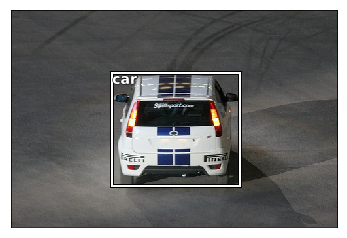

In [22]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [23]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [24]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


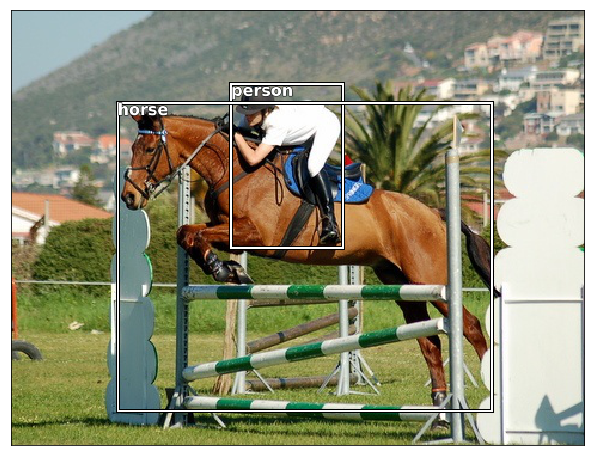

In [25]:
draw_idx(17)

## Largest item classifier

In [54]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [55]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

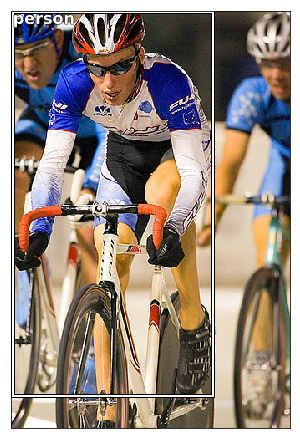

In [56]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [57]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [58]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [59]:
f_model = resnet34
sz=224
bs=64

In [60]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

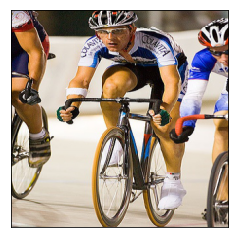

In [61]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [63]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [85]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████████████████████████████████████████████████████▍               | 25/32 [00:15<00:04,  1.66it/s, loss=10.5]

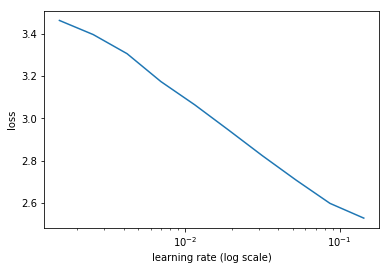

In [86]:
learn.sched.plot()

In [64]:
lr = 3e-2

In [65]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.398658   0.660141   0.799579  



[0.6601409, 0.7995793297886848]

In [50]:
lrs = np.array([lr/1000,lr/100,lr])

In [51]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [54]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]


Exception in thread Thread-22:
Traceback (most recent call last):
  File "C:\Users\j\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\j\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\j\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.886063   0.660145   0.816256  



[0.66014504, 0.816256009042263]

In [55]:
learn.unfreeze()

In [56]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.68359    0.605503   0.830829  
    1      0.457855   0.578427   0.826923                                                                              



[0.5784272, 0.8269230797886848]

## Bbox only

In [26]:
BB_CSV = PATH/'tmp/bb.csv'

In [43]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [27]:
f_model=resnet34
sz=224
bs=64

In [28]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [29]:
x,y=next(iter(md.val_dl))

In [30]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 48.,   0., 134., 207.], dtype=float32)

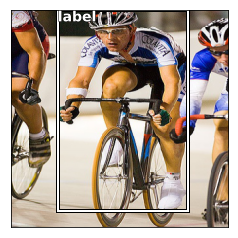

In [31]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [32]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [33]:
learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|████████████████████████████████████████████████████████▎               | 25/32 [00:18<00:05,  1.38it/s, loss=397]

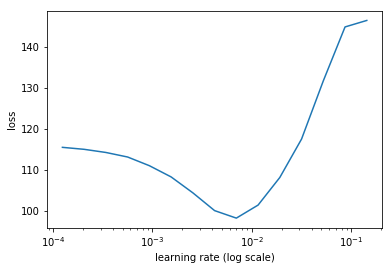

In [34]:
learn.sched.plot(5)

In [70]:
lr = 1e-3

In [71]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      51.215931  37.805145 
    1      39.737713  29.35638                                                                                         
    2      33.372342  28.710142                                                                                        



[28.710142]

In [74]:
lrs = np.array([lr/100,lr/10,lr])

In [75]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      102.406115 91141120000.0



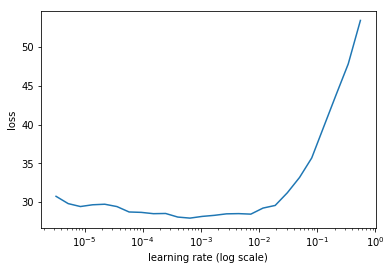

In [106]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [76]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      25.746012  24.210987 
    1      22.049259  21.504528                                                                                        
    2      18.373643  20.880943                                                                                        



[20.880943]

In [134]:
learn.freeze_to(-3)

In [135]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      15.501107  22.094254 
    1      14.894885  20.156548                                                                                        



[20.156548]

In [77]:
learn.save('reg4')

In [69]:
learn.load('reg4')

In [78]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

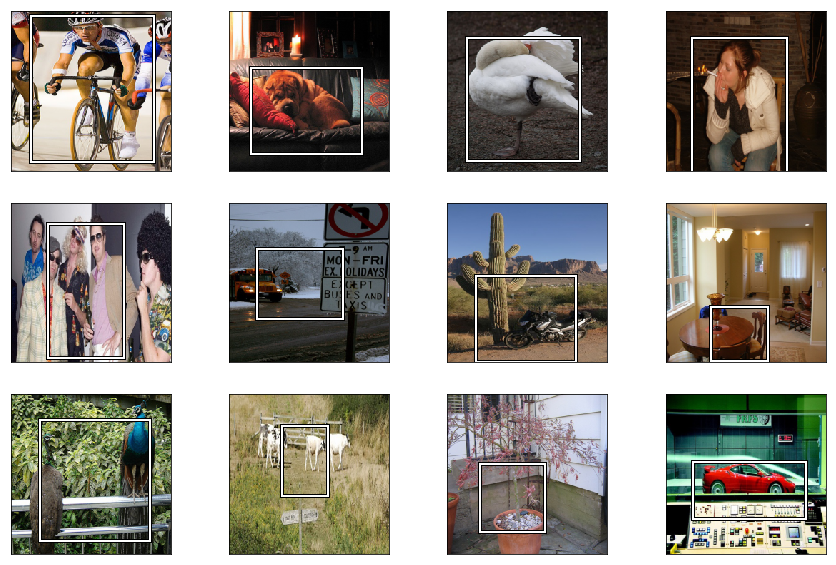

In [79]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(y[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)

## Single object detection

In [66]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [68]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, num_workers=4, val_idxs=val_idxs)

In [71]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

array([ 6, 12, 14, ..., 16, 14,  6], dtype=int64)

In [70]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [73]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [74]:
x,y=next(iter(md.val_dl))

In [75]:
ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  0.,  62., 223., 161.], dtype=float32)

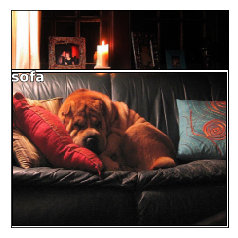

In [77]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [78]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [79]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████████████████████████████████████████████████████████████████▊  | 31/32 [00:16<00:00,  1.90it/s, loss=678]

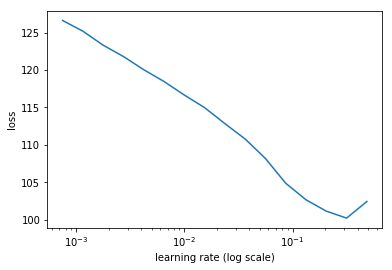

In [80]:
learn.lr_find()
learn.sched.plot()

In [81]:
lr=1e-2

In [345]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1                                                                    
    0      74.791056  43.460373  0.807392   30.980663 
    1      52.291478  36.317711  0.83128    25.43541                                                                   
    2      41.869822  35.500114  0.828425   24.775492                                                                  



[35.500114, 0.8284254819154739, 24.775491952896118]

In [346]:
learn.save('reg1_0')

In [347]:
learn.freeze_to(-2)

In [86]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████████████████████████████████████████████████████████████▎      | 29/32 [00:35<00:03,  1.23s/it, loss=134]

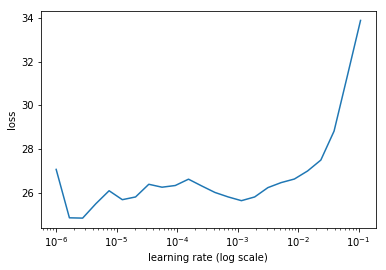

In [340]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [349]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1                                                                    
    0      34.028101  35.528641  0.80649    22.902847 
    1      28.719974  32.164253  0.826923   21.211                                                                     
    2      24.727553  37.043209  0.754357   21.518424                                                                  
    3      21.806619  32.075912  0.804087   20.376304                                                                  
    4      19.325486  31.502956  0.826022   20.059161                                                                  



[31.502956, 0.826021634042263, 20.059160947799683]

In [351]:
learn.save('reg1_1')

In [353]:
learn.load('reg1_1')

In [354]:
learn.unfreeze()

In [355]:
learn.fit(lrs/5, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

 12%|█████████                                                               | 4/32 [00:07<00:54,  1.96s/it, loss=15.8]


Exception in thread Thread-218:
Traceback (most recent call last):
  File "C:\Users\j\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\j\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\j\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1                                                                    
    0      16.813009  34.602329  0.811899   21.236256 
    1      18.946937  34.548538  0.798227   20.380577                                                                  
    2      18.454516  35.793682  0.784555   19.986296                                                                  
    3      17.058397  32.824471  0.794321   18.923163                                                                  
    4      15.890228  32.637703  0.811899   19.224218                                                                  
    5      14.740342  32.642921  0.807091   19.100917                                                                  
    6      13.765002  31.985876  0.815355   18.49737                                                                   
    7      12.754753  31.124172  0.822115   18.441445                                                    

[30.754723, 0.818209134042263, 18.184754133224487]

In [92]:
learn.save('reg1')

In [89]:
learn.load('reg1')

In [93]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [94]:
from scipy.special import expit

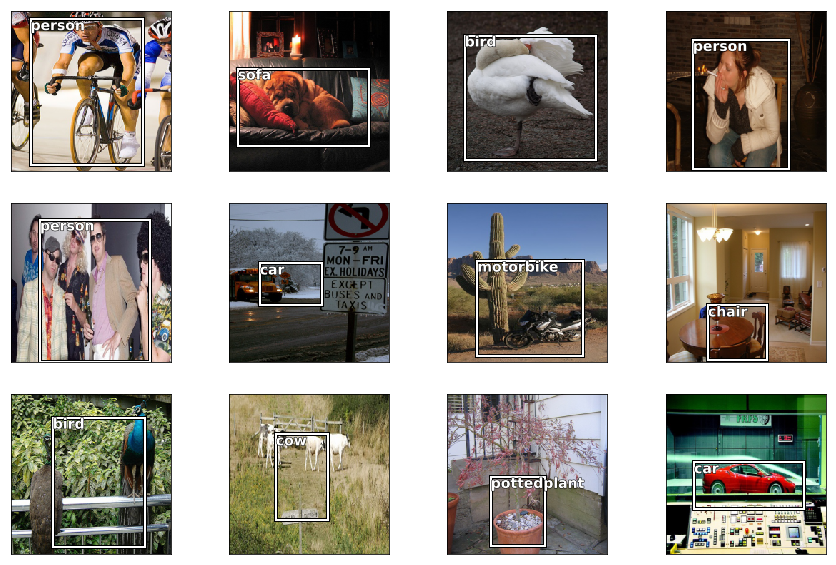

In [95]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])

## End